## Titanic competition

#####  Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In [1]:
#my info
__author__ = "Vitor Sousa"
__email__ = "vitorsousavhcs@outlook.com"

In [81]:
# libraries
import pandas as pd
import sklearn as sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

# machine learning
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

## Functions

In [86]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def pivot_feature(df, feature):
   return df[[feature, 'Survived']].groupby([feature], as_index=False).mean().sort_values(by='Survived', ascending=False)

def clean_data(df):
    clean_df = df.drop(['PassengerId','Ticket', 'Cabin'], axis=1)
    return clean_df

def define_null_age(df,sex, pclass):
    ages_df = df[(df['Sex'] == sex) & (df['Pclass'] == pclass)]['Age'].dropna()
    age_median = ages_df.median()
    df.loc[(df.Age.isnull()) & (df.Sex == sex) & (df.Pclass == pclass), 'Age'] = age_median
    return df

def add_feature_isAlone_family(df):
    df.loc[(df['SibSp'] > 0) | (df['Parch'] > 0), 'isAlone'] = 1
    df.loc[(df['SibSp'] == 0) & (df['Parch'] == 0), 'isAlone'] = 0
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    df.isAlone.astype(int)
    return df

def add_title(df):
    stat_min = 10 #http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_names = (df['Title'].value_counts() < stat_min)
    df['Title'] = df['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    return df

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

### Load Data

In [87]:
train_df = load_file('data/train.csv')
test_df = load_file('data/test.csv')

### Data Exploration

In [9]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [12]:
train_df.duplicated().sum()

0

In [13]:
test_df.duplicated().sum()

0

In [14]:
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']
categorical_cols = ['Name', 'Sex', 'Ticket']

In [15]:
train_df.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Rice, Master. Eugene",male,347082,B96 B98,S
freq,1,577,7,4,644


#### First analysis
The data have some problems.

The age feature have a higly probability to be correlated to survival and have some empty values.
The embarked feature could also be correlated with the survival and are only 2 rows without a value.
Th cabin have a higly percentage of null values, the best is drop this feature.

The ticket have high ratio of duplicates(23.5%), the feature could be dropped.
PassegerId should be dropped.
The Name feature should also be dropped.

###### Feature Engineering

Create a feature that inclue the parch and sibsp features, represent the total count of family members on board.
(Age and Fare) to categorical features??? 


In [17]:
pivot_feature(train_df,'Pclass')

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [18]:
pivot_feature(train_df,'Sex')

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [19]:
pivot_feature(train_df,'SibSp')

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [20]:
pivot_feature(train_df,'Parch')

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [21]:
sns.set_color_codes("pastel")

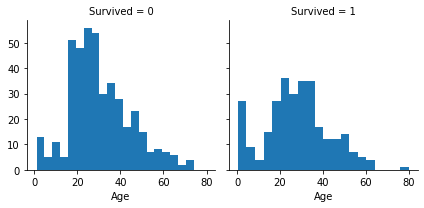

In [22]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

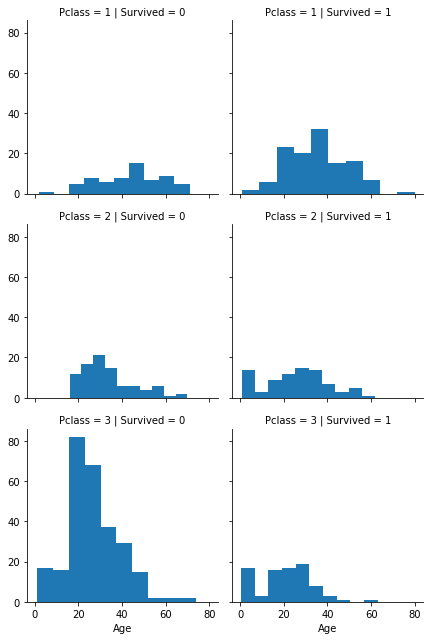

In [23]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age')
grid.add_legend();

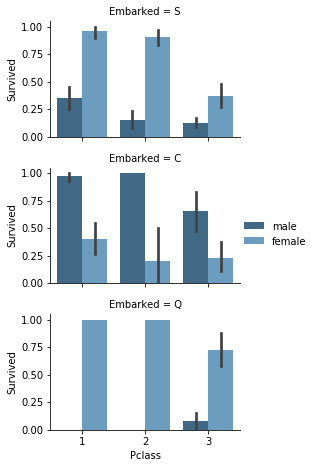

In [89]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Pclass', 'Survived', 'Sex', palette="Blues_d",order=None, hue_order=None)
grid.add_legend()

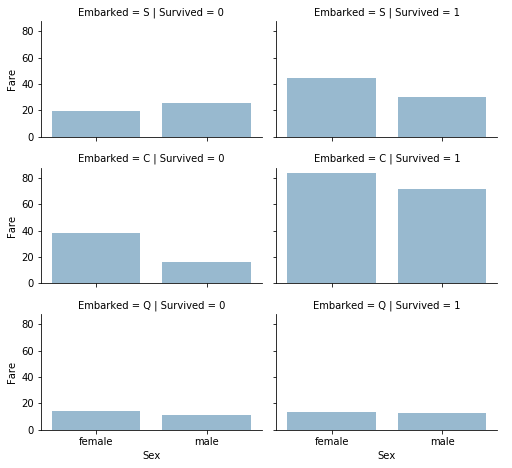

In [91]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

#### Pivot Analysis
these graphs allow a better analysis of the accident data and some relationships between surviving fatalities and some characteristics of the passengers.
The survival rate between class variate significantly, the higher class has a survival rate greater. Women have a survival rate greater than men. The passages that have less family on the boat, 'Sibsp' and 'Parch', were more likely to survive

#### Clean & Transform Data

In [92]:
train_df = clean_data(train_df)
test_df = clean_data(test_df)

In [93]:
combine = [train_df, test_df]

In [94]:
train_df = add_title(train_df)
test_df = add_title(test_df)

In [29]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Misc,0.444444
2,Miss,0.697802
3,Mr,0.156673
4,Mrs,0.792000


In [95]:
train_df = train_df.drop('Name', axis=1)
test_df = test_df.drop('Name', axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 8))

In [96]:
train_df.Sex = LabelEncoder().fit_transform(train_df.Sex)
test_df.Sex = LabelEncoder().fit_transform(test_df.Sex)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,S,Mr
1,1,1,0,38.0,1,0,71.2833,C,Mrs
2,1,3,0,26.0,0,0,7.9250,S,Miss
3,1,1,0,35.0,1,0,53.1000,S,Mrs
4,0,3,1,35.0,0,0,8.0500,S,Mr


### Complete missing values
#### Age

With base on Gender and Class and the median age the missing values gonna be set.

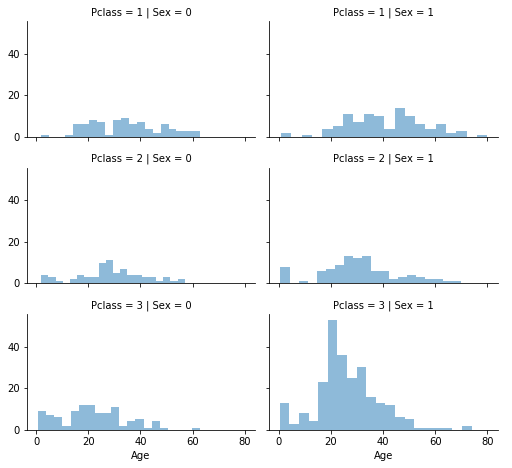

In [97]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [98]:
## define age to all pclass and sex combinations on train dataframe
train_df = define_null_age(train_df,0, 1)
train_df = define_null_age(train_df,1, 1)
train_df = define_null_age(train_df,0, 2)
train_df = define_null_age(train_df,1, 2)
train_df = define_null_age(train_df,0, 3)
train_df = define_null_age(train_df,1, 3)
## define the Age feature as int 
train_df.Age = train_df.Age.astype(int)

In [99]:
# define age to all pclass and sex combinatins on test dataframe 
test_df = define_null_age(test_df,0, 1)
test_df = define_null_age(test_df,1, 1)
test_df = define_null_age(test_df,0, 2)
test_df = define_null_age(test_df,1, 2)
test_df = define_null_age(test_df,0, 3)
test_df = define_null_age(test_df,1, 3)
## define the Age feature as int
test_df.Age = test_df.Age.astype(int)

In [100]:
train_df['Age'] = pd.cut(train_df['Age'], 5,labels=[1,2,3,4,5])
test_df['Age'] = pd.cut(test_df['Age'], 5,labels=[1,2,3,4,5])
pivot_feature(train_df, 'Age')

,Age,Survived
0,1,0.550000
3,4,0.434783
2,3,0.412037
1,2,0.337374
4,5,0.090909


In [101]:
train_df = add_feature_isAlone_family(train_df)
test_df = add_feature_isAlone_family(test_df)

In [102]:
# full the feature embarked with mode value 
freq_port = train_df.Embarked.dropna().mode()[0]
train_df.Embarked = train_df.Embarked.fillna(freq_port)
test_df.Embarked = test_df.Embarked.fillna(freq_port)

In [103]:
train_df.Embarked = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_df.Embarked = test_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [104]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
train_df['Fare'] = pd.qcut(train_df['Fare'], 4,labels=[1,2,3,4])
test_df['Fare'] = pd.qcut(test_df['Fare'], 4,labels=[1,2,3,4])

In [105]:
train_df.Title = train_df.Title.map( {'Master': 0, 'Mr': 1, 'Miss': 2, 'Misc':3, 'Mrs':4} ).astype(int)
test_df.Title = test_df.Title.map( {'Master': 0, 'Mr': 1, 'Miss': 2, 'Misc':3, 'Mrs':4} ).astype(int)

In [106]:
train_df = shuffle(train_df).reset_index(drop=True)

In [107]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 3

#shared model paramaters
verbose_lvl = 0

#vars
numerical_vars = list(train_df.columns)

#
feature_df = train_df.drop('Survived', axis=1)
target_df = train_df.Survived

In [108]:
cv = StratifiedKFold(10, shuffle=True, random_state=42)

dt = DecisionTreeClassifier()   

rf = RandomForestClassifier(criterion='gini',
                            n_estimators=1750,
                            max_depth=7,
                            min_samples_split=6,
                            min_samples_leaf=6,
                            max_features='auto',
                            oob_score=True,
                            random_state=42,
                            n_jobs=-1,
                            verbose=0)

lg = lgb.LGBMClassifier(max_bin=4,
                        num_iterations=550,
                        learning_rate=0.0114,
                        max_depth=3,
                        num_leaves=7,
                        colsample_bytree=0.35,
                        random_state=42,
                        n_jobs=-1)

xg = xgb.XGBClassifier(
    n_estimators=2800,
    min_child_weight=0.1,
    learning_rate=0.002,
    max_depth=2,
    subsample=0.47,
    colsample_bytree=0.35,
    gamma=0.4,
    reg_lambda=0.4,
    random_state=42,
    n_jobs=-1,
)

svc = SVC(probability=True)

logreg = LogisticRegression(n_jobs=-1, solver='newton-cg')

gb = GradientBoostingClassifier(random_state=42)

gnb = GaussianNB()

mlp = MLPClassifier(random_state=42)

models.extend([dt, rf, lg, xg, svc, logreg, gb, gnb, mlp ])

In [109]:
#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Average MSE:
 0.2042525318687963
Standard deviation during CV:
 0.01099410490250416

Model:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=1750,
                       

In [110]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(feature_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)


Predictions calculated using model with lowest MSE:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=1750,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)


In [111]:
neg_mse = cross_val_score(rm, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
mean_mse[rm] = -1.0*np.mean(neg_mse)
cv_std[rm] = np.std(neg_mse)

In [113]:
submission_df = pd.read_csv('data/test.csv')
submission = pd.DataFrame({
        "PassengerId": submission_df["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('submission.csv', index=False)